In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl
!unzip indian-sign-language-isl.zip


Streaming output truncated to the last 5000 lines.
  inflating: Indian/V/819.jpg        
  inflating: Indian/V/82.jpg         
  inflating: Indian/V/820.jpg        
  inflating: Indian/V/821.jpg        
  inflating: Indian/V/822.jpg        
  inflating: Indian/V/823.jpg        
  inflating: Indian/V/824.jpg        
  inflating: Indian/V/825.jpg        
  inflating: Indian/V/826.jpg        
  inflating: Indian/V/827.jpg        
  inflating: Indian/V/828.jpg        
  inflating: Indian/V/829.jpg        
  inflating: Indian/V/83.jpg         
  inflating: Indian/V/830.jpg        
  inflating: Indian/V/831.jpg        
  inflating: Indian/V/832.jpg        
  inflating: Indian/V/833.jpg        
  inflating: Indian/V/834.jpg        
  inflating: Indian/V/835.jpg        
  inflating: Indian/V/836.jpg        
  inflating: Indian/V/837.jpg        
  inflating: Indian/V/838.jpg        
  inflating: Indian/V/839.jpg        
  inflating: Indian/V/84.jpg         
  inflating: Indian/V/840.jpg        

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


In [ ]:
data_dir = '/content/Indian'  # Path to your dataset
categories = ['1', '2', '3', '4', '5', '6', '7', '8', '9'] + [chr(i) for i in range(65, 91)]  # 1-9 and A-Z

images = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_img = cv2.resize(img_array, (64, 64))  # Resize to 64x64 for consistency
            images.append(resized_img)
            labels.append(class_num)
        except Exception as e:
            pass

images = np.array(images).reshape(-1, 64, 64, 1) / 255.0  # Normalize images
labels = np.array(labels)

# Split the data into training and testing datasets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to avoid overfitting
model.add(Dense(len(categories), activation='softmax'))  # Output layer for classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,290,403 (12.55 MB)

 Trainable params: 3,290,403 (12.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1069/1069 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.3109 - loss: 2.2859 - val_accuracy: 0.9697 - val_loss: 0.1032
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.7577 - loss: 0.6722 - val_accuracy: 0.9934 - val_loss: 0.0354
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.8314 - loss: 0.4547 - val_accuracy: 0.9749 - val_loss: 0.0513
Epoch 4/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.8583 - loss: 0.3902 - val_accuracy: 0.9918 - val_loss: 0.0260
Epoch 5/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.8839 - loss: 0.3232 - val_accuracy: 0.9932 - val_loss: 0.0119
Epoch 6/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8984 - loss: 0.2902 - val_accuracy: 0.9953 - val_loss: 0.0138
Epoch 7/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.9088 - loss: 0.2556 - val_accuracy: 0.9957 - val_loss: 0.0092
Epoch 8/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.9232 - loss: 0.21

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9983 - loss: 0.0070
Test Loss: 0.007205524016171694
Test Accuracy: 0.9978944659233093


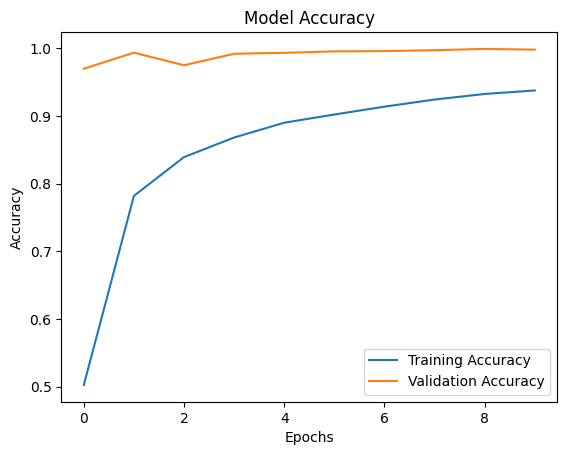

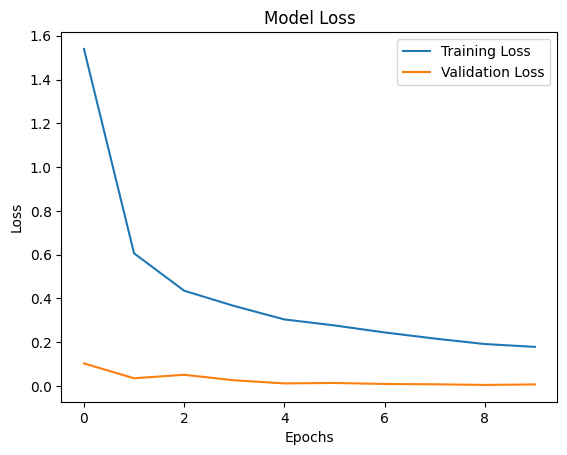

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Saving the model in the recommended Keras format
model.save('my_model.keras')


268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


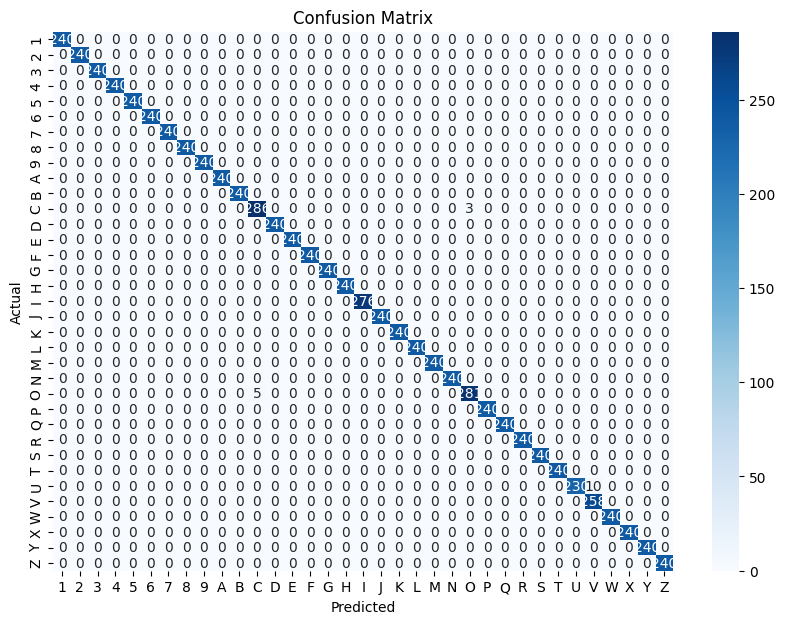

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       240
           3       1.00      1.00      1.00       240
           4       1.00      1.00      1.00       240
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       240
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       240
           A       1.00      1.00      1.00       240
           B       1.00      1.00      1.00       240
           C       0.98      0.99      0.99       289
           D       1.00      1.00      1.00       240
           E       1.00      1.00      1.00       240
           F       1.00      1.00      1.00       240
           G       1.00      1.00      1.00       240
           H       1.00      1.00      1.00       240
           I       1.00    

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
# Ensure that the number of categories matches the number of unique labels in y_true_classes and y_pred_classes
unique_labels = sorted(set(y_true_classes) | set(y_pred_classes))
print(classification_report(y_true_classes, y_pred_classes, labels=unique_labels, target_names=categories))


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

# Upload an image for prediction
uploaded = files.upload()

# Load the uploaded image
img_path = list(uploaded.keys())[0]  # Get the uploaded image name
img = image.load_img(img_path, target_size=(64, 64), color_mode='grayscale')  # Load and resize to (64, 64)
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch size
img_array = img_array / 255.0  # Normalize

# Predict the sign language character
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
predicted_label = categories[predicted_class]

print(f'Predicted Sign: {predicted_label}')


Saving A.jpg to A.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Sign: A


In [ ]:
from google.colab import files

# Save the model in the recommended .keras format
model.save('sign_language_model.keras')

# Download the model file
files.download('sign_language_model.keras')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>